# Übung 6: Kantendetektion und Hough Transformation

Student: Remo Schwarzentruber

##  Kantendetektion mit Canny

Mit dem Canny Detektor können Kanten in einem Bild detektiert werden. Das von Canny bereits 1987 etnwickelte Verfahren betrachtet die Kantenerkennung als Optimisierungsproblem und besteht in der Anwendung im wesentlichen aus 3 Schritten:

- Ermittlung der Kantenstärke durch Ableitungsfilter
- Finden des lokalen Maxima senkrecht zur Kante
- Hysteresis Thresholding mit 2 Schwellwerten unter Berücksichtigung der Verbindungen zwischen den Pixeln


In [2]:
# OpenCV needs to be included first
import cv2
import numpy as np
import math

# for displaying images in jupyter
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi'] = 500

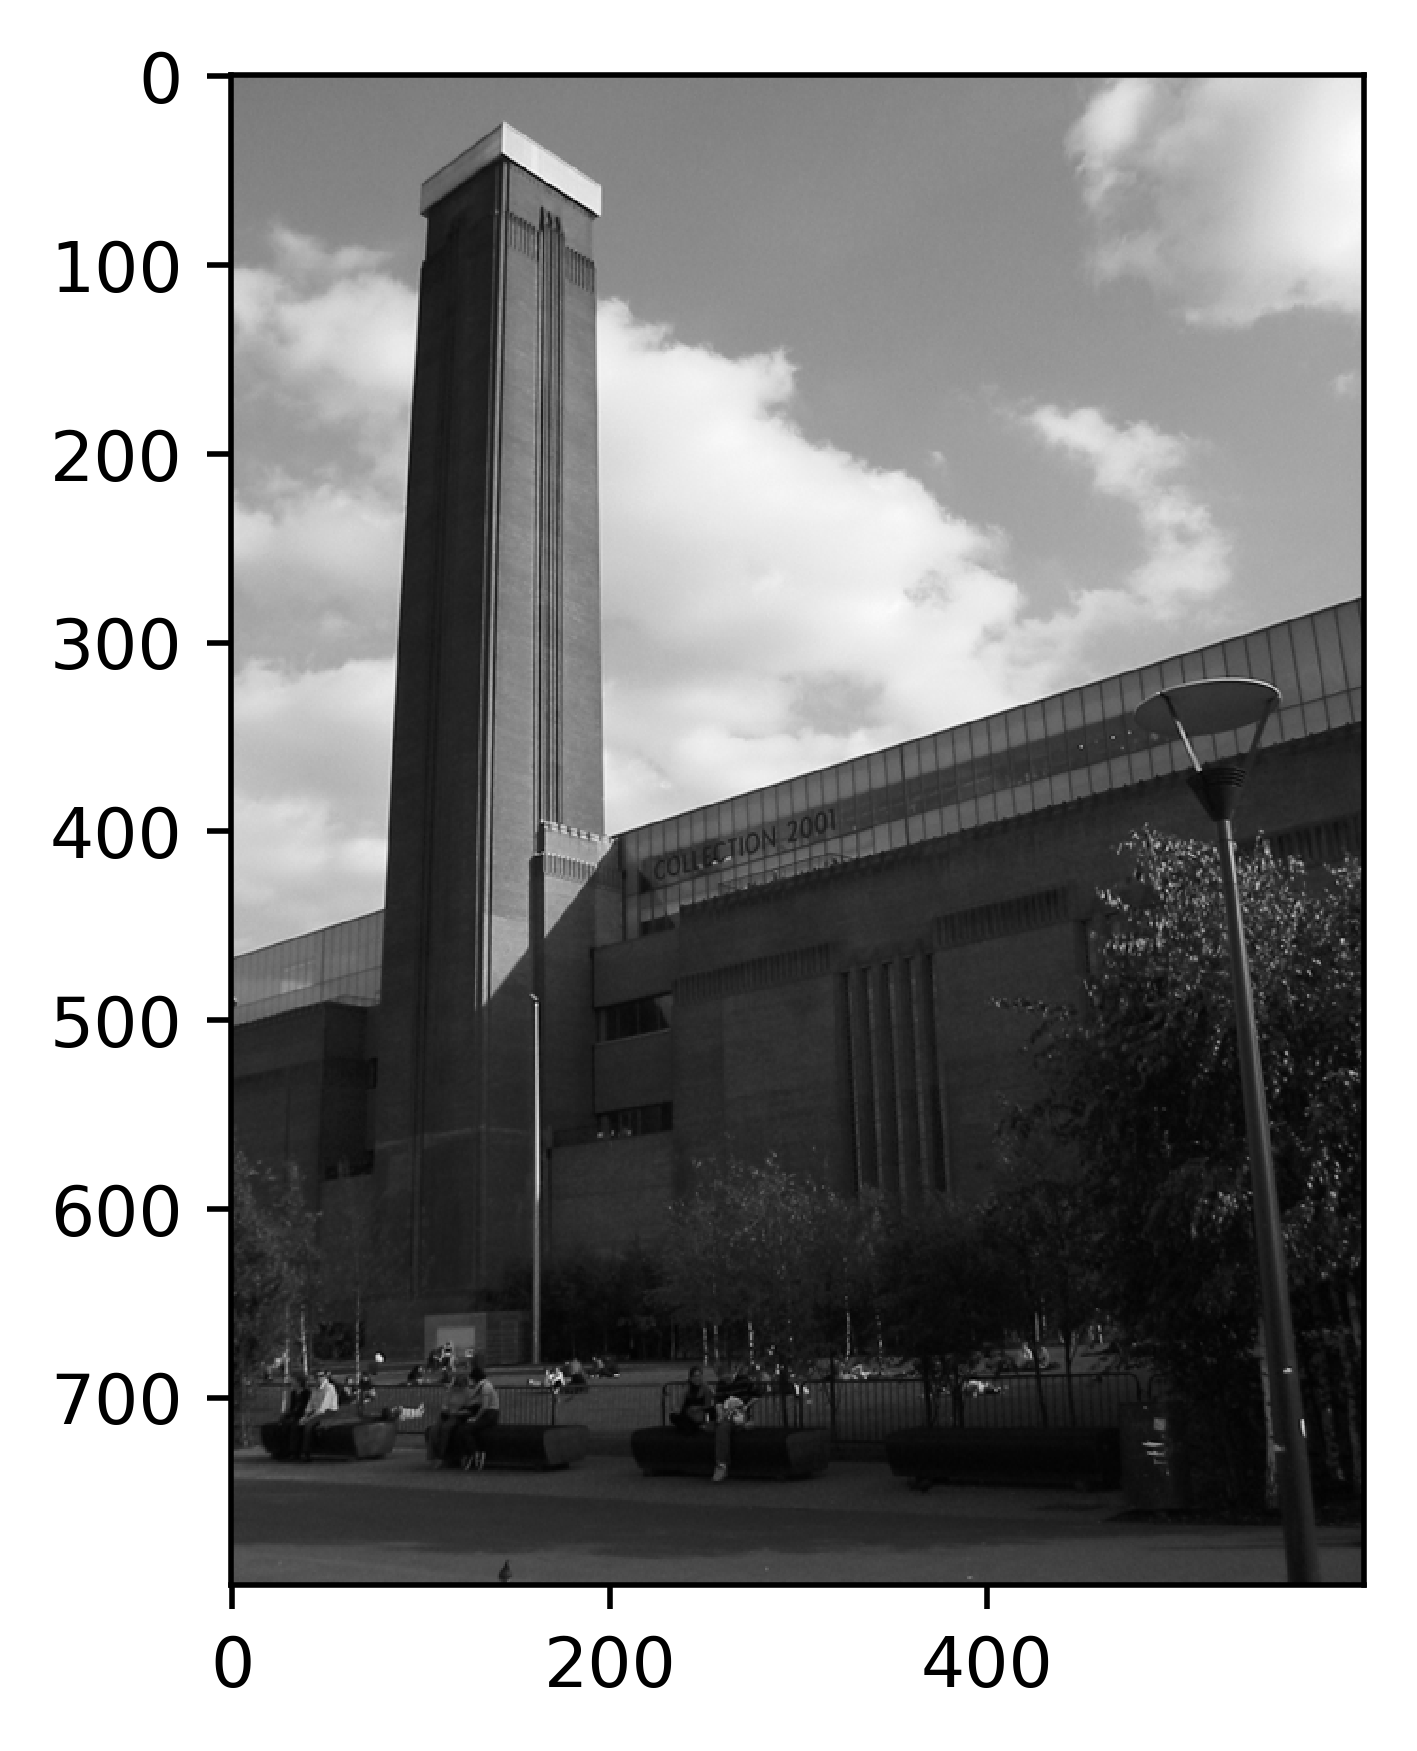

In [3]:
image  = cv2.imread('../data/londonSmall.png')
plt.imshow(image)

### Aufgabe 1: Kantendetektion
Detektieren Sie auf obigen Bild die Kanten mit dem in OpenCV eingebauten Canny Detektor. Wir wirken sich die Parameter aus?

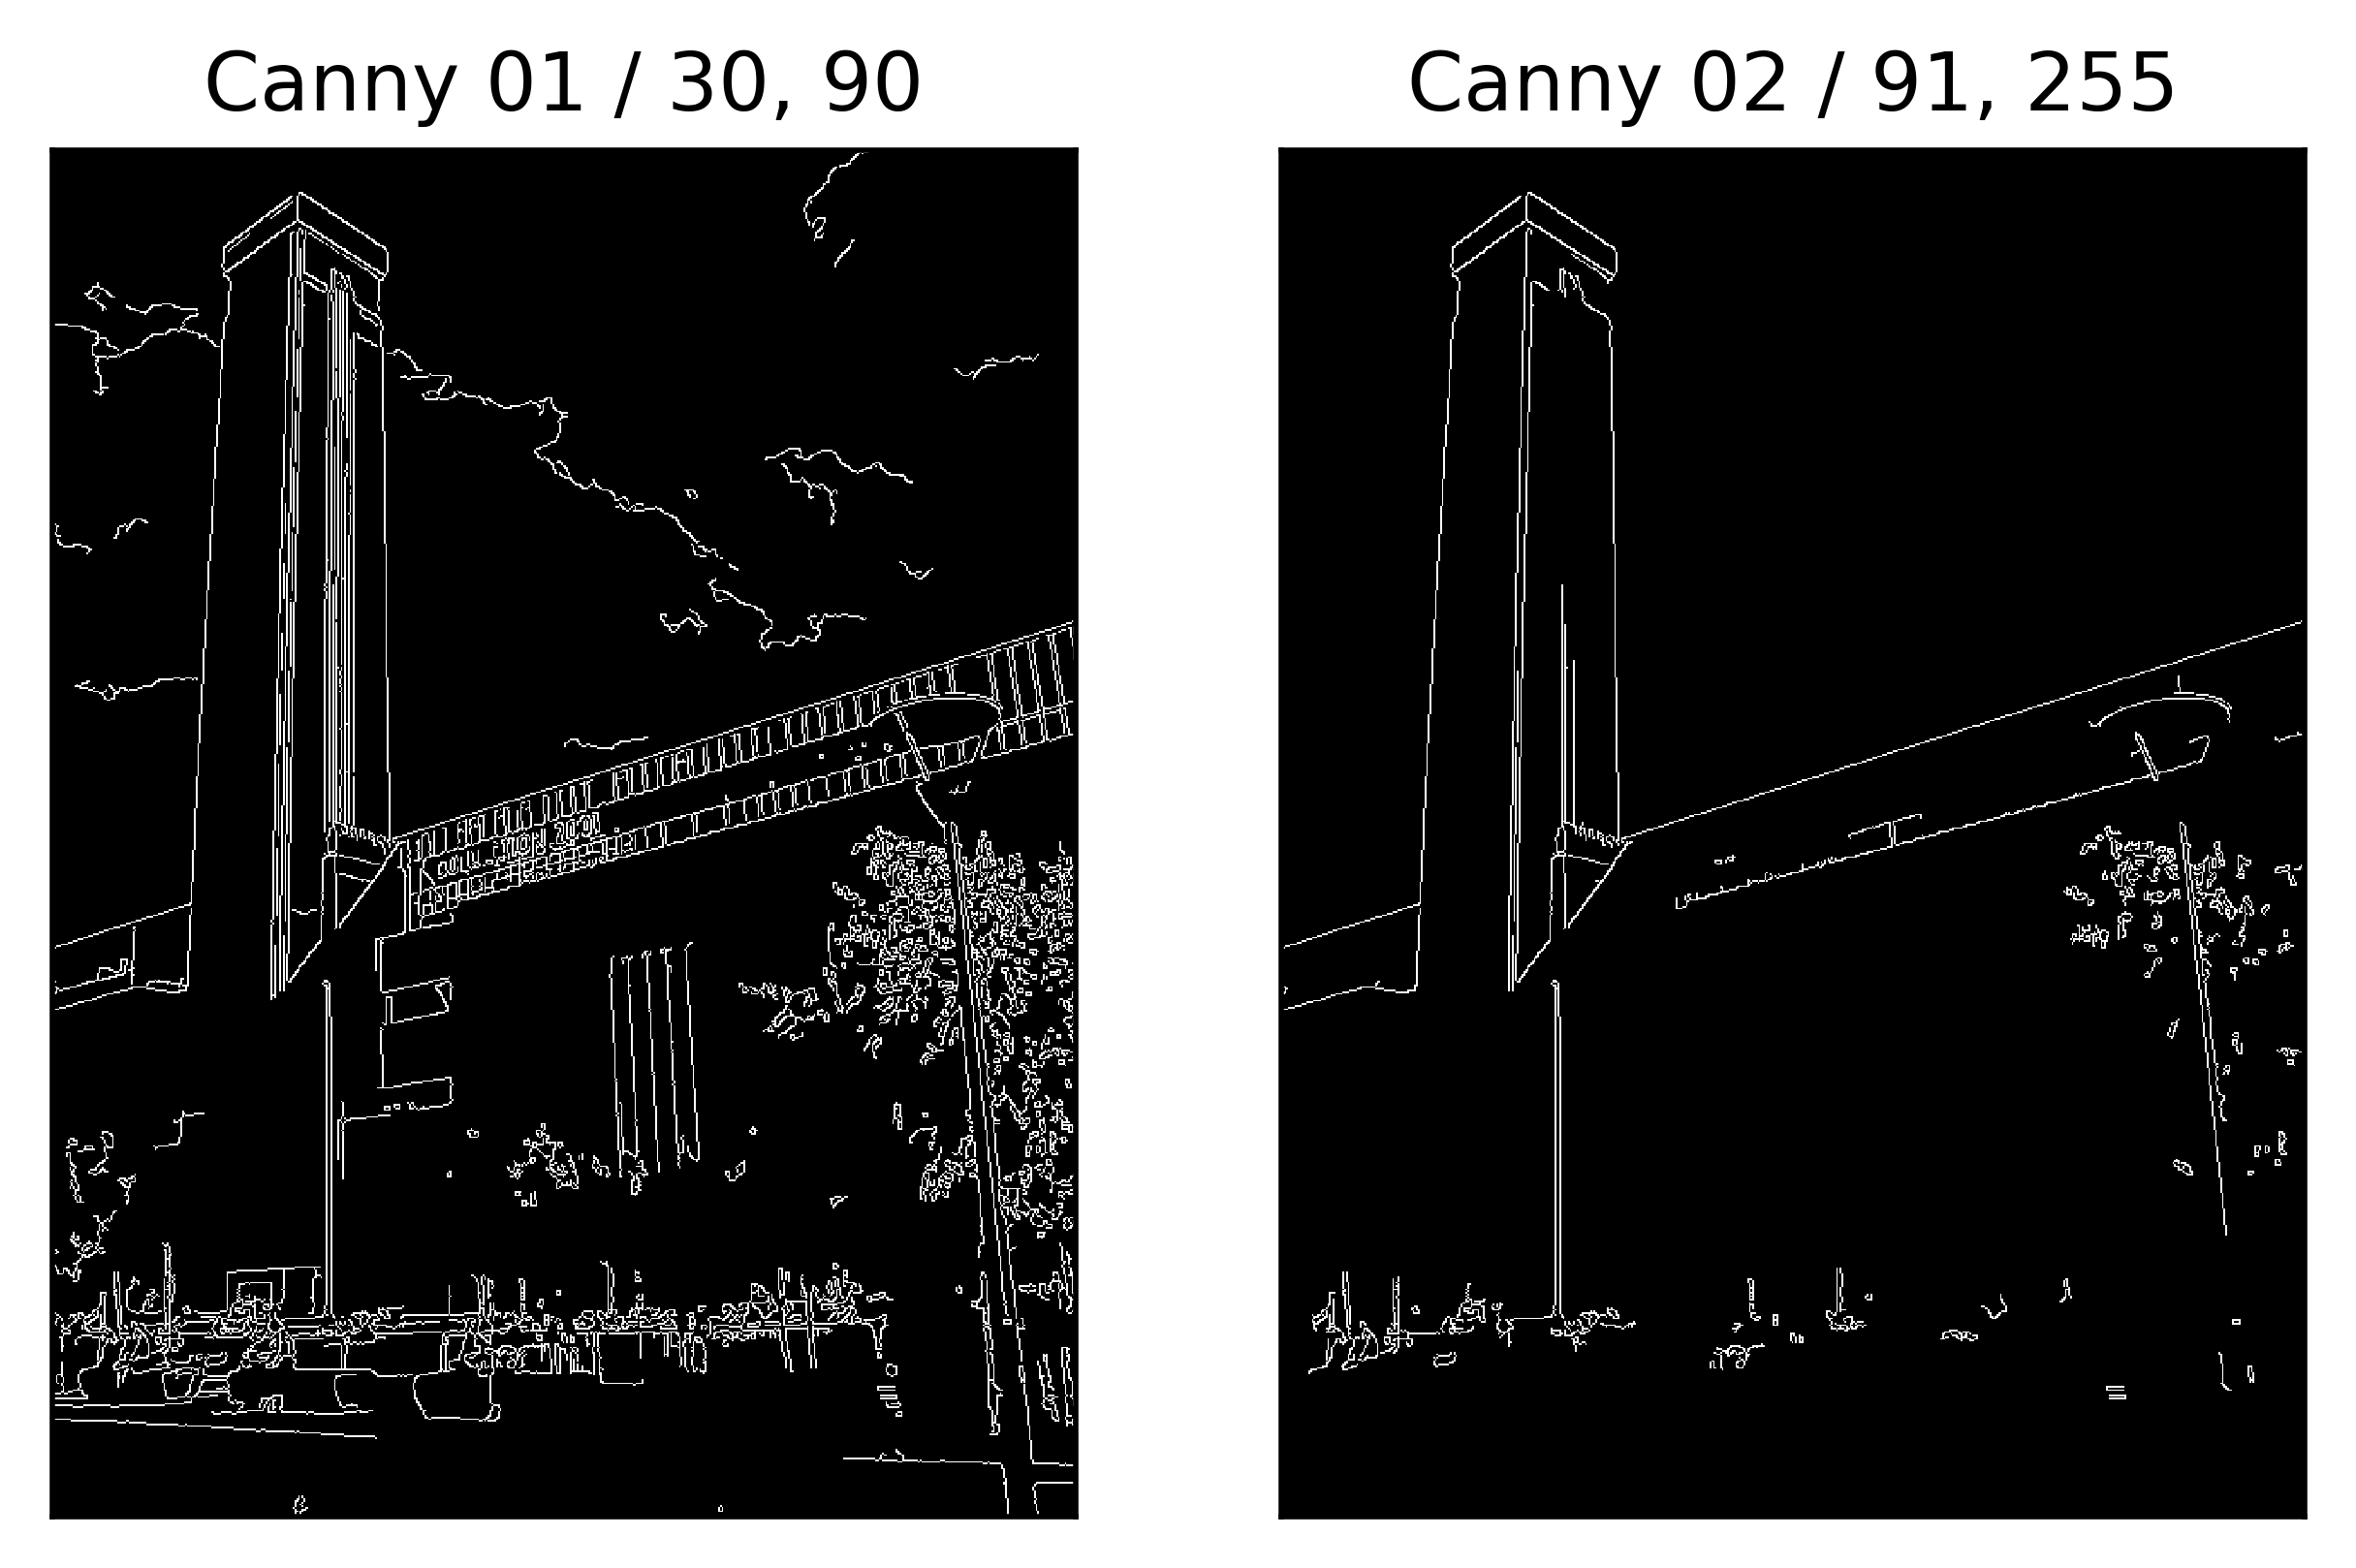

In [4]:
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img_gray_blurred = cv2.GaussianBlur(img_gray, (3,3), 0)

canny01 = cv2.Canny(img_gray_blurred, 30, 90)
canny02 = cv2.Canny(img_gray_blurred, 91, 255)

# 30 / 90 or 91, 255 => threshold

plt.subplot(1, 2, 1)
plt.title("Canny 01 / 30, 90"), plt.xticks([]), plt.yticks([])
plt.imshow(canny01, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Canny 02 / 91, 255"), plt.xticks([]), plt.yticks([])
plt.imshow(canny02, cmap='gray')

plt.show()

### Aufgabe 2:  Canny Filter auf verschiedenen Auflösungsstufen

Der in OpenCV implementierte Canny Filter erlaubt nicht sehr viele Parameter Angaben, insbesondere ist es nicht möglich ihn direkt auf verschiedenen Auflösungsstufen anzuwenden. Dies können wir aber umgehen, indem wir die Ableitungen selber berechnen.

Dazu wollen wir zuerst das Bild mit einem Gaussfilter glätten und dann davon die ersten Ableitungen in x und y berechnen.

Benutzen Sie dazu die Funktionen `GaussianBlur` und dann `Sobel`. Am besten verwenden Sie für die Ableitungen 16bit Integer, die können dann später direkt wieder in der Canny Funktion verwendet werden.

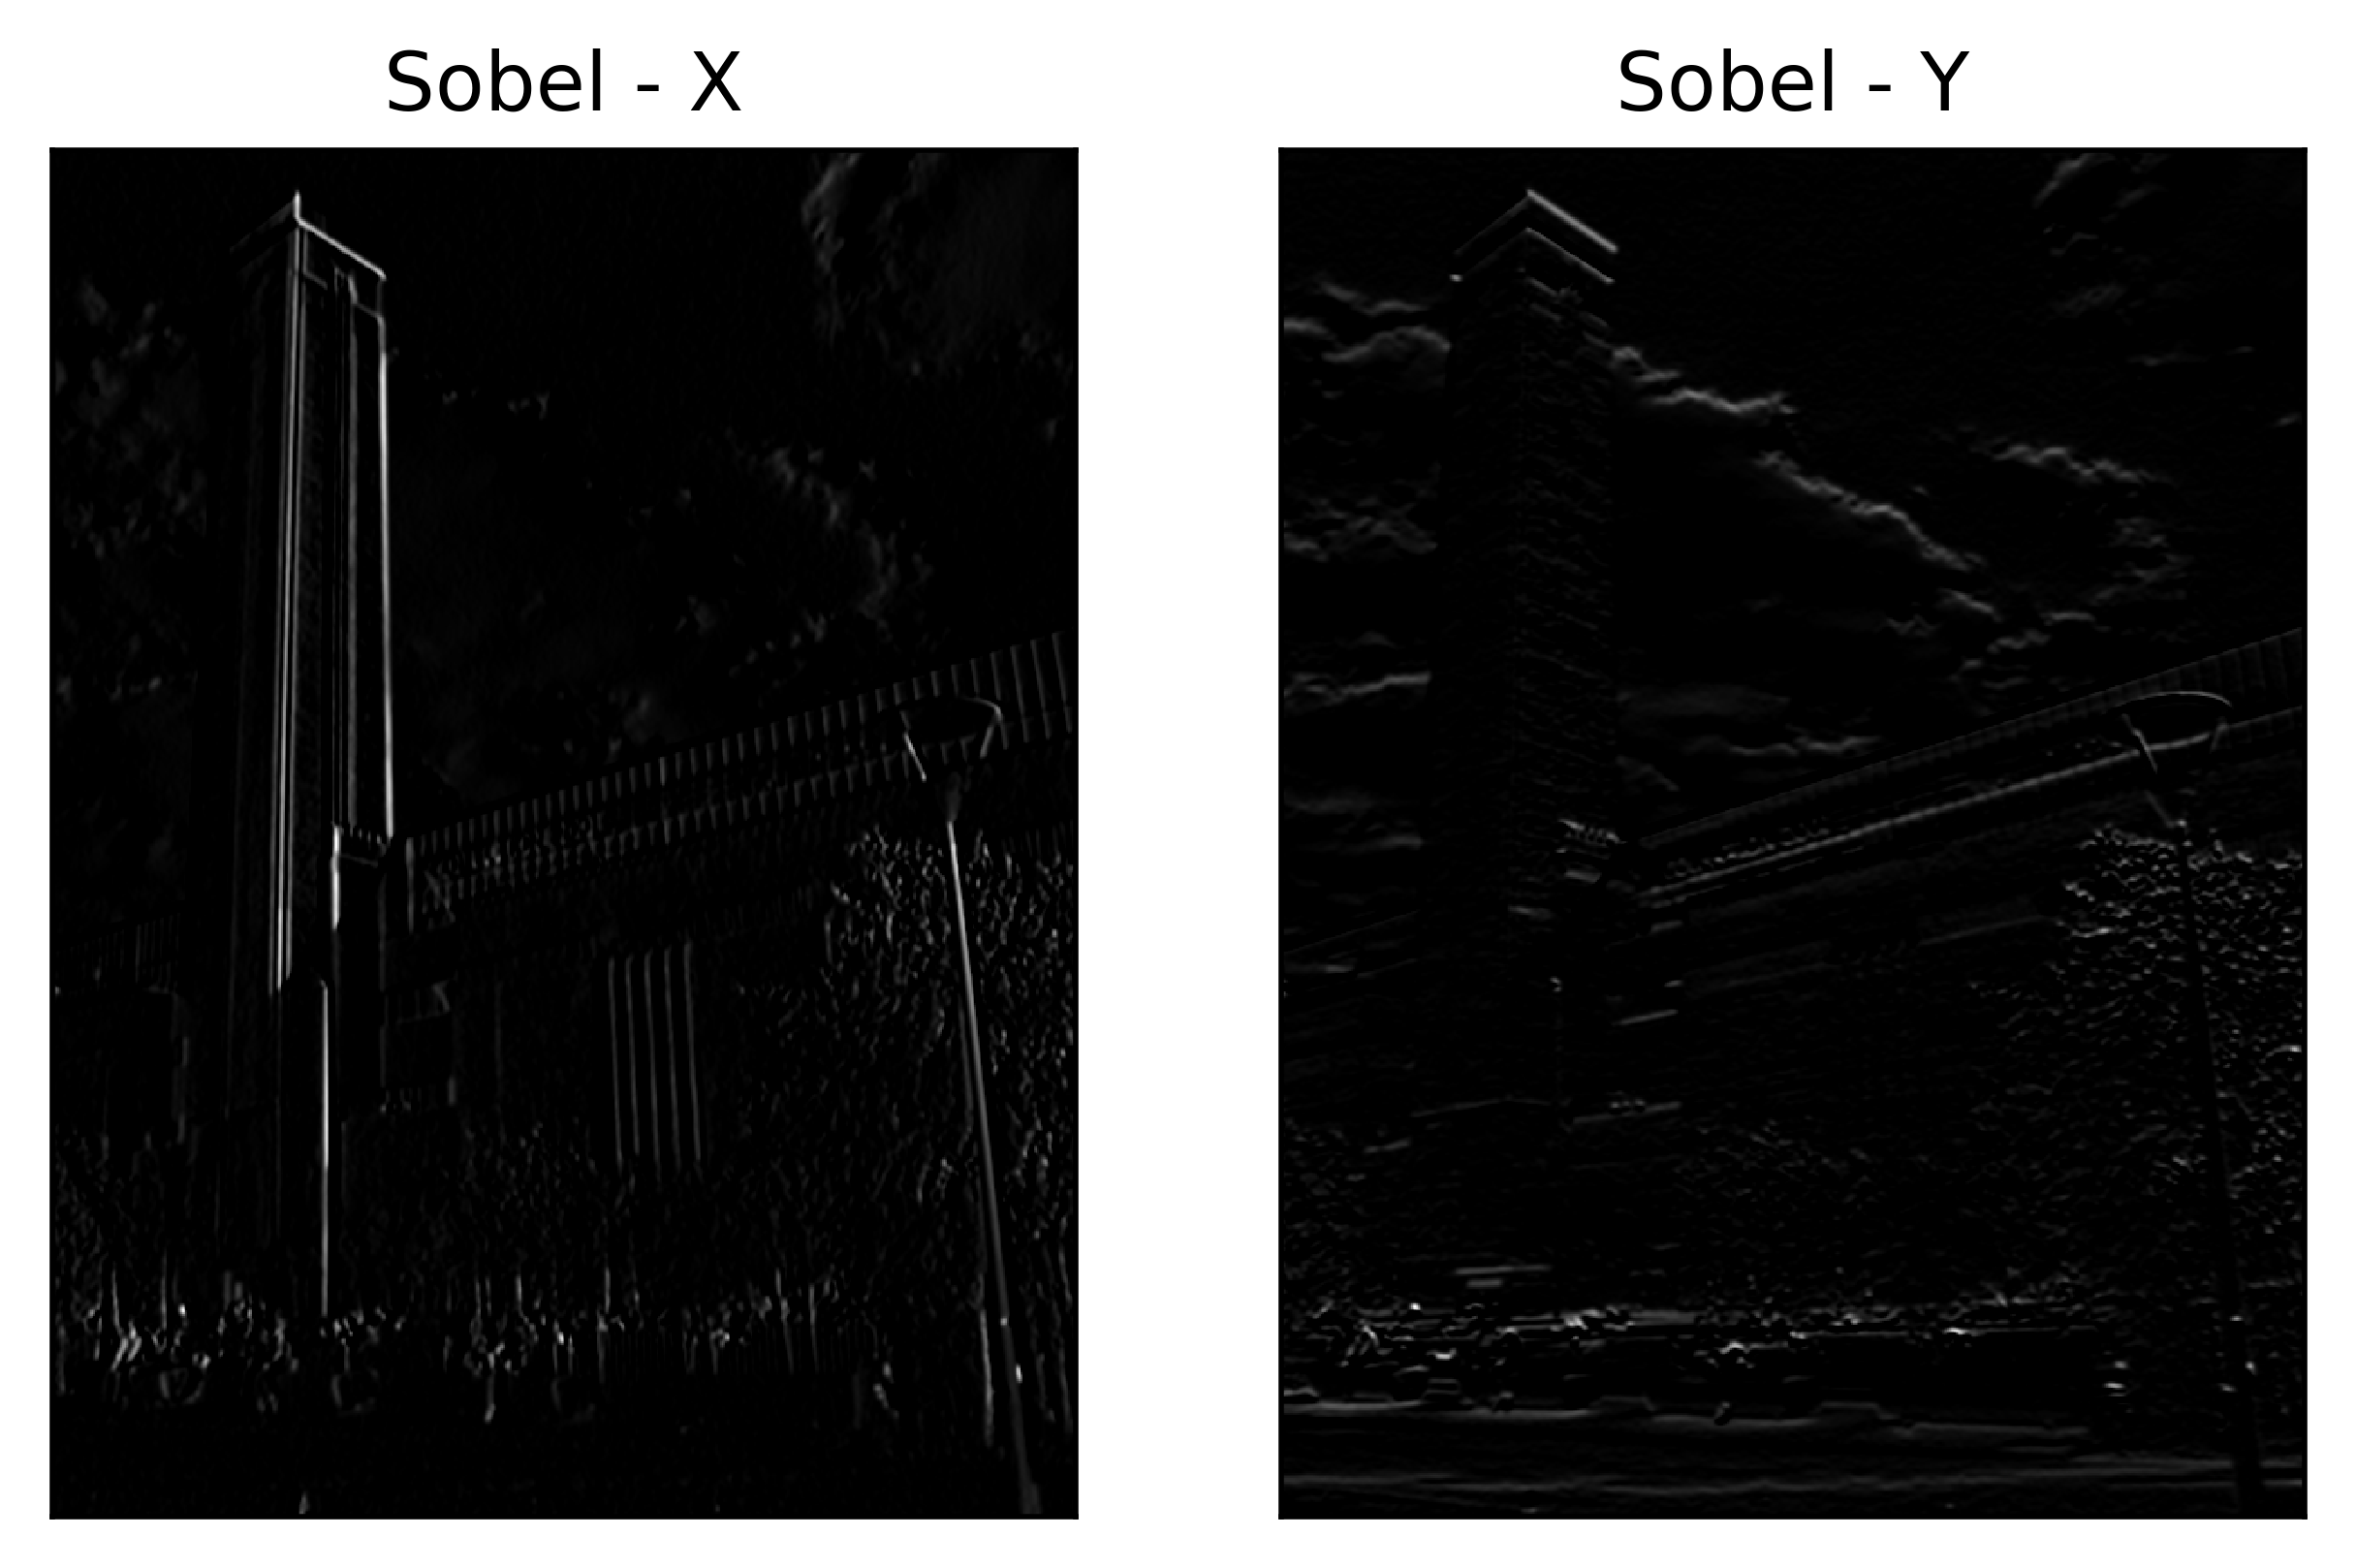

In [5]:
# blur
img_gray_blurred_02 = cv2.GaussianBlur(img_gray, (5,5), 0)

# Sobel
sobel_x = cv2.Sobel(img_gray_blurred_02, cv2.CV_16U, 1, 0, ksize=5) # d/dx
sobel_y = cv2.Sobel(img_gray_blurred_02, cv2.CV_16U, 0, 1, ksize=5) # d/d<

# Plot
plt.subplot(1, 2, 1)
plt.title("Sobel - X"), plt.xticks([]), plt.yticks([])
plt.imshow(sobel_x, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Sobel - Y"), plt.xticks([]), plt.yticks([])
plt.imshow(sobel_y, cmap='gray')

plt.show()

Stellen Sie dar Resultat der Ableitungen dar (wie?) und berechnen Sie auch die Kantenstärke als 

$$ \text{edge} = \sqrt{dx^2 + dy^2} $$

und stellen Sie diese dar.


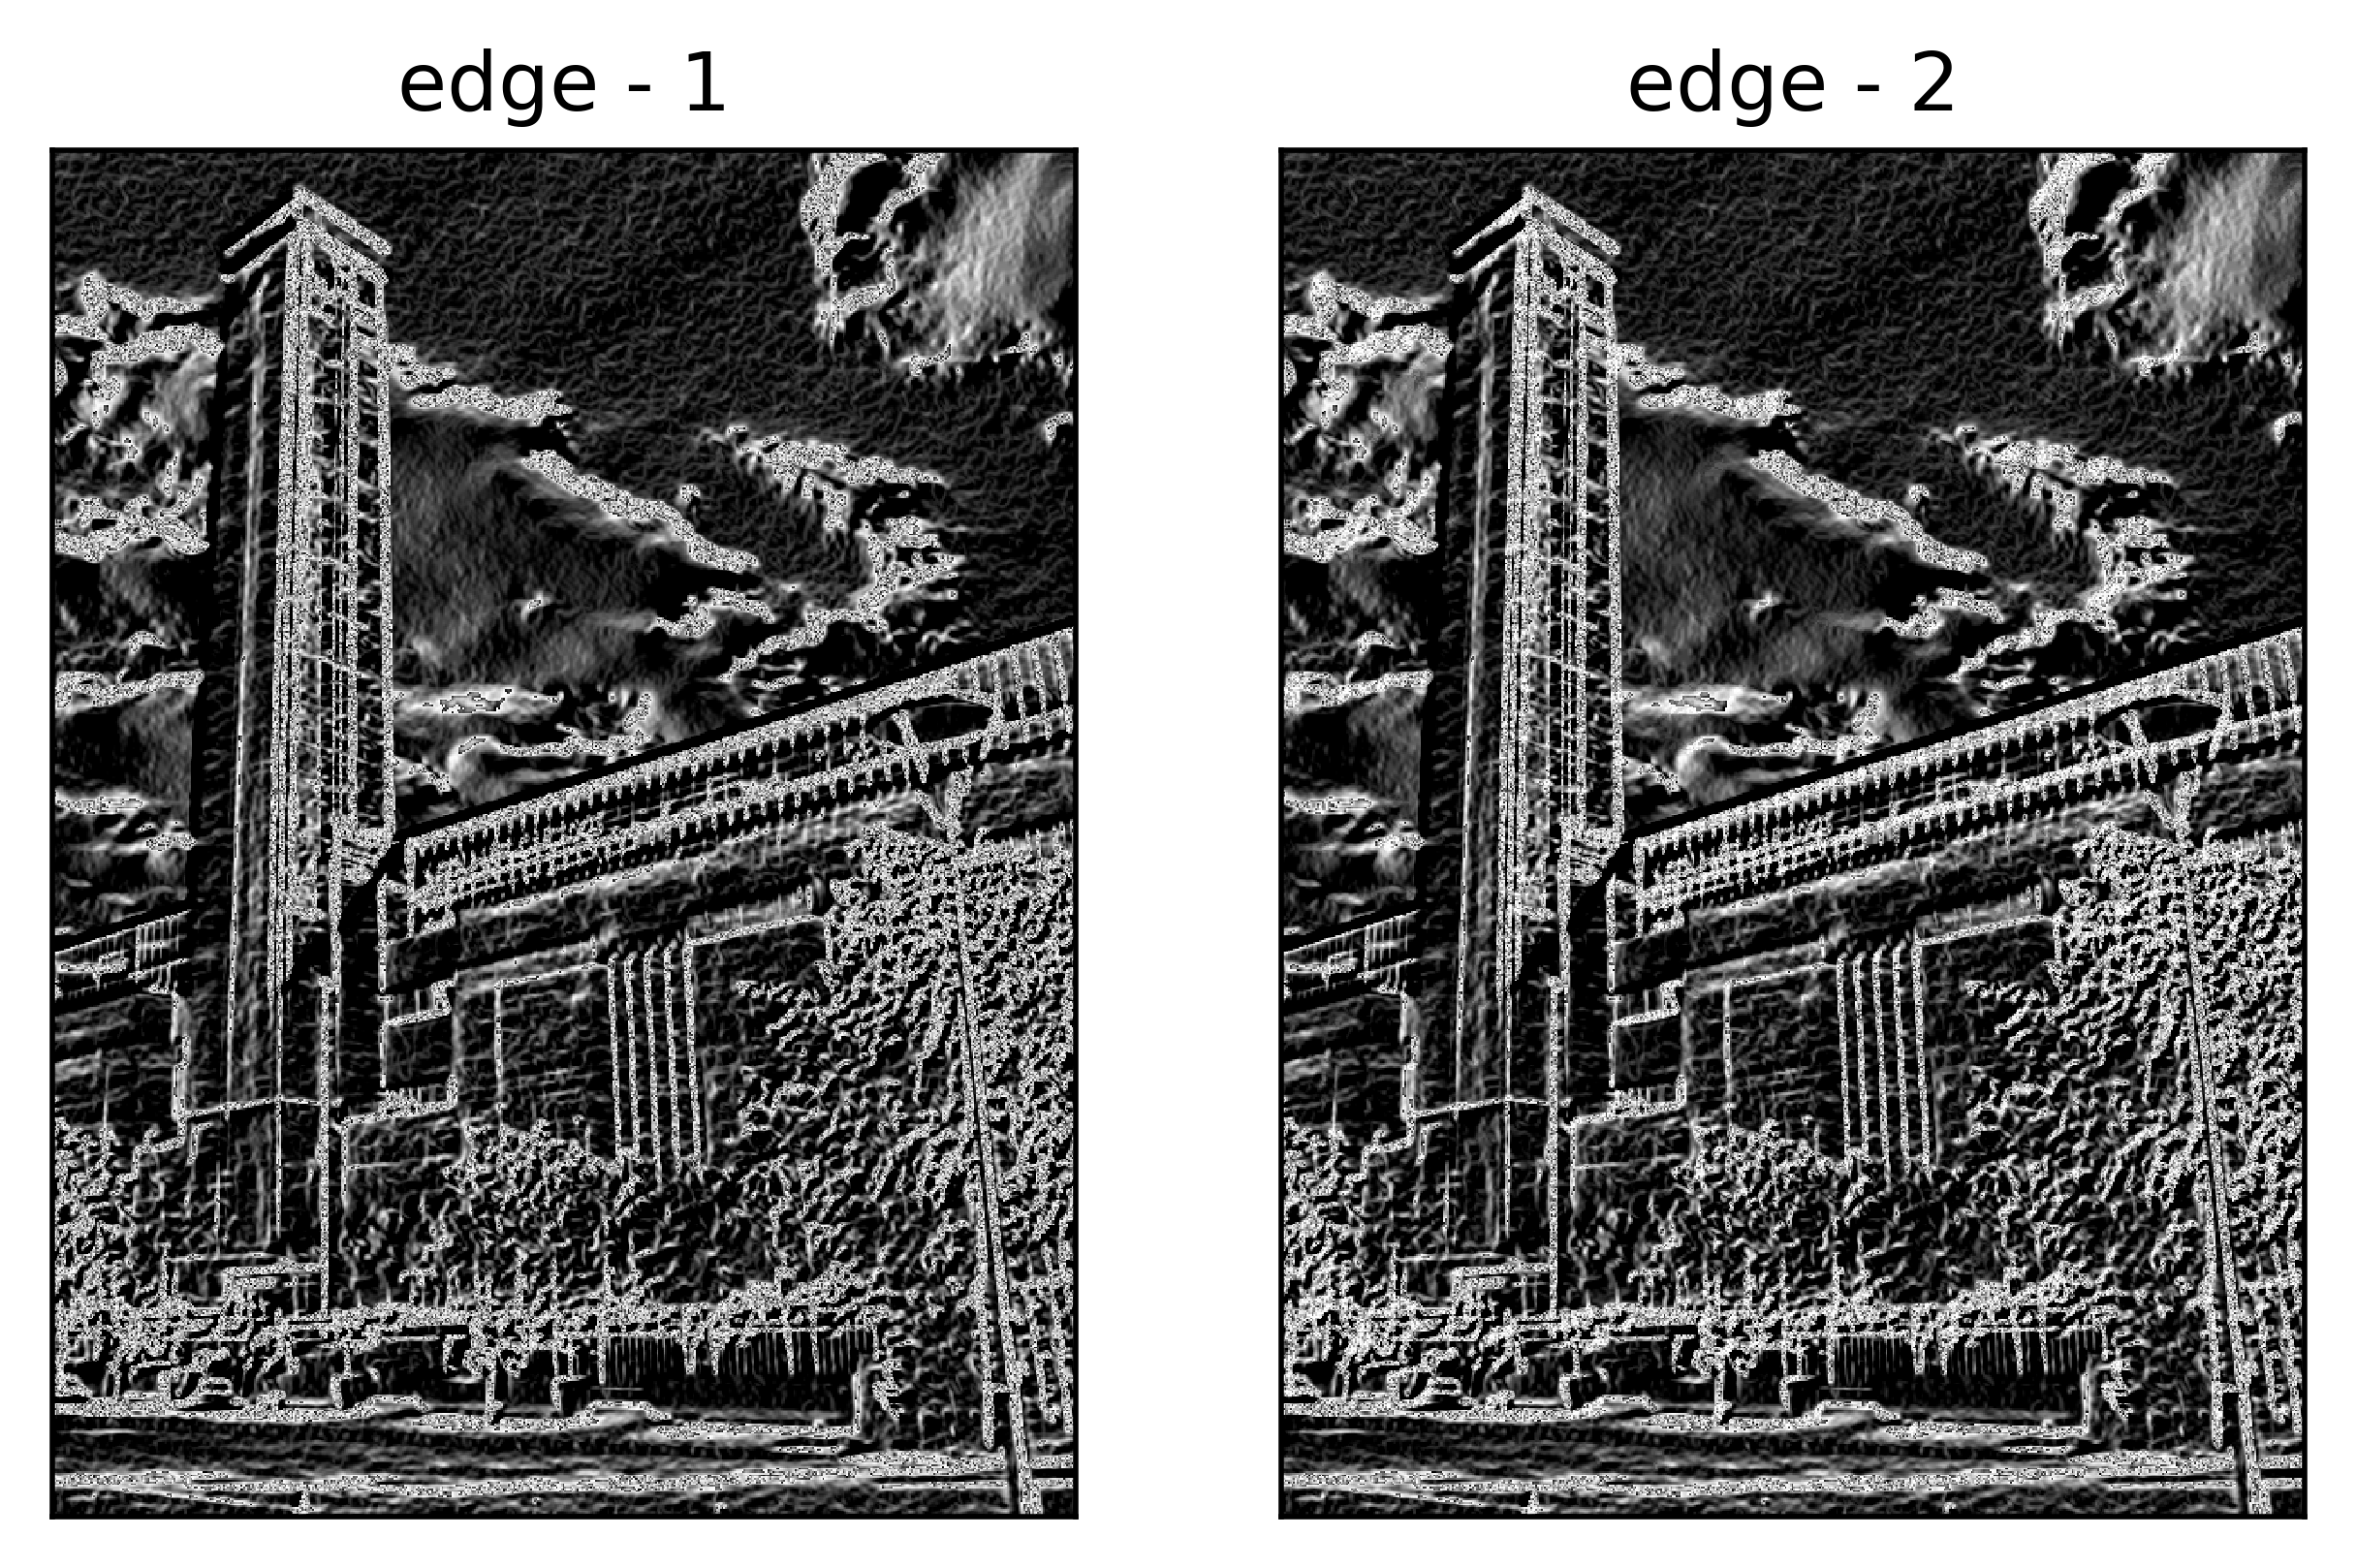

In [6]:
# edges
# square root of sum of squares of derivatives
edge_01 = np.sqrt(np.add(np.square(sobel_x), np.square(sobel_y)))

# with bitwise_or
edge_02 = np.sqrt(cv2.bitwise_or(np.square(sobel_x), np.square(sobel_y)))

# Plot
plt.subplot(1, 2, 1)
plt.title("edge - 1"), plt.xticks([]), plt.yticks([])
plt.imshow(edge_01, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("edge - 2"), plt.xticks([]), plt.yticks([])
plt.imshow(edge_02, cmap='gray')

plt.show()

Wenden Sie nun nochmals Canny an, aber geben Sie dabei die bereits definierten Ableitungen mit.

Experimentieren Sie mit verschiedenen Werten für das Sigma beim `GaussianBlur`. Wie wirkt sich der Parameter auf die Kanten aus?

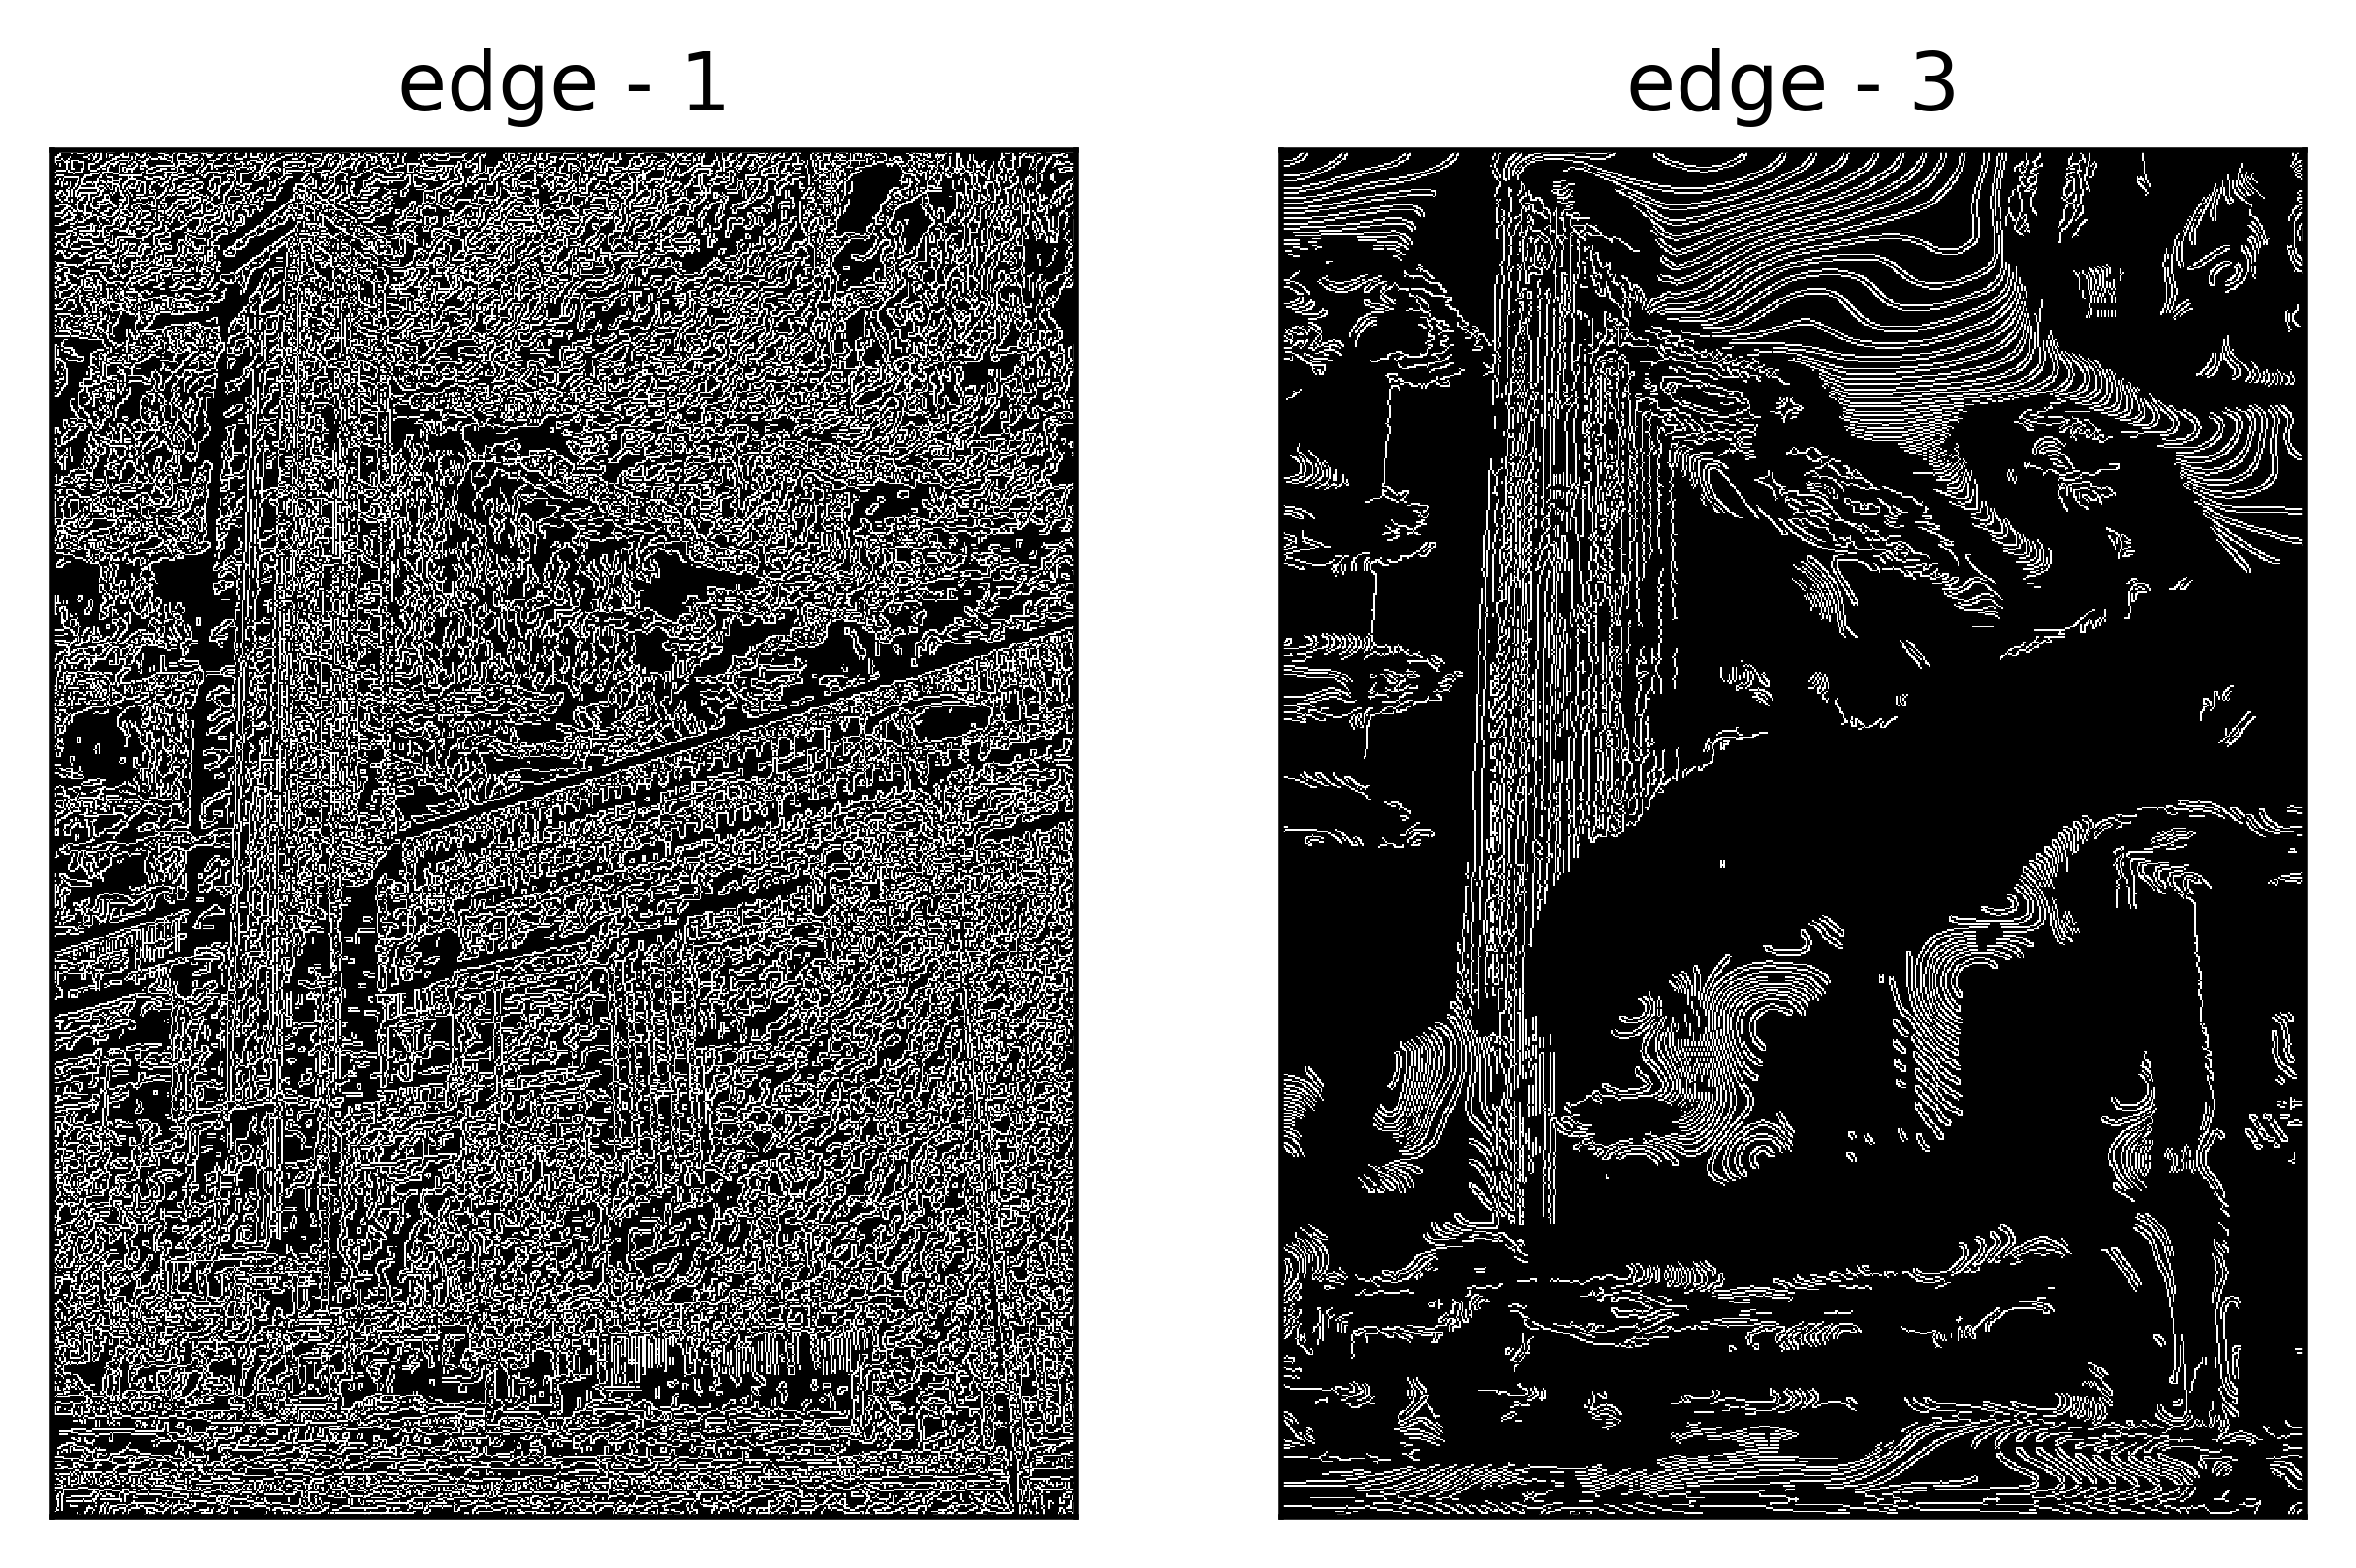

In [7]:
img_gray_blurred_03 = cv2.GaussianBlur(img_gray, (99,99), 0)

# sobel (derivatives in x & y, d/dx, d/dy)
sobel_x_02 = cv2.Sobel(img_gray_blurred_03, cv2.CV_16U, 1, 0, ksize=5) # d/dx
sobel_y_02 = cv2.Sobel(img_gray_blurred_03, cv2.CV_16U, 0, 1, ksize=5) # d/dy

# edges
edge_03 = np.sqrt(np.add(np.square(sobel_x_02),np.square(sobel_y_02)))

# casting + canny
edge_01_copy = np.uint8(edge_01)
edge_03_copy = np.uint8(edge_03)
canny_03 = cv2.Canny(edge_01_copy, 80, 160)
canny_04 = cv2.Canny(edge_03_copy, 80, 160)

# Plot
plt.subplot(1, 2, 1)
plt.title("edge - 1"), plt.xticks([]), plt.yticks([])
plt.imshow(canny_03, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("edge - 3"), plt.xticks([]), plt.yticks([])
plt.imshow(canny_04, cmap='gray')

plt.show()

Fact:

* Blurring senkt die Anzahl Kanten

## Hough Transformation

Die Hough Transformation wirde verwendet um Geraden in einem Bild zu erkennen.

Dafür stehen verschiedene Implementationen zur Verfügung, diejenige in OpenCV ist als `cv2.HoughLines` verfügbar und berechnet direkt die gefundenen Linien. Diejenige in `skimage.transform` braucht 2 Schritte mit den Funktionen `'hough_lines'` um zuerst den Akkumulator zu berechnen und `'hough_lines_peaks'` um die Maxima zu finden. Dafür lässt sich damit der Akkumulator darstellen

Verwenden Sie `HoughLines` um im Kantenbild die Geraden zu finden und stellen Sie das Ergebnis und den Akkumulator da.

In [8]:
# image
img_gray_hough = img_gray
# convert to rgb (for line printing in color)
img_hough = cv2.cvtColor(img_gray_hough, cv2.COLOR_GRAY2RGB)
# blur
img_hough_blurred = cv2.GaussianBlur(img_hough, (9, 9), 0)
# canny
canny05 = cv2.Canny(img_hough_blurred, 30, 90, 3)
# hough
lines = cv2.HoughLines(canny05, 1, np.pi / 180, 63, None, 0, 0)

Stellen Sie die gefundenen Geraden nun auf dem Bild dar. Ein Beispiel dazu finden Sie auf

http://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html#sphx-glr-auto-examples-edges-plot-line-hough-transform-py

Sie müssen dazu von den Polarkoordinaten auf kartesische Kooridnaten umrechnen und die zwei Endpunkte der Gerade bestimmen.

INFO: found 129 line(s)


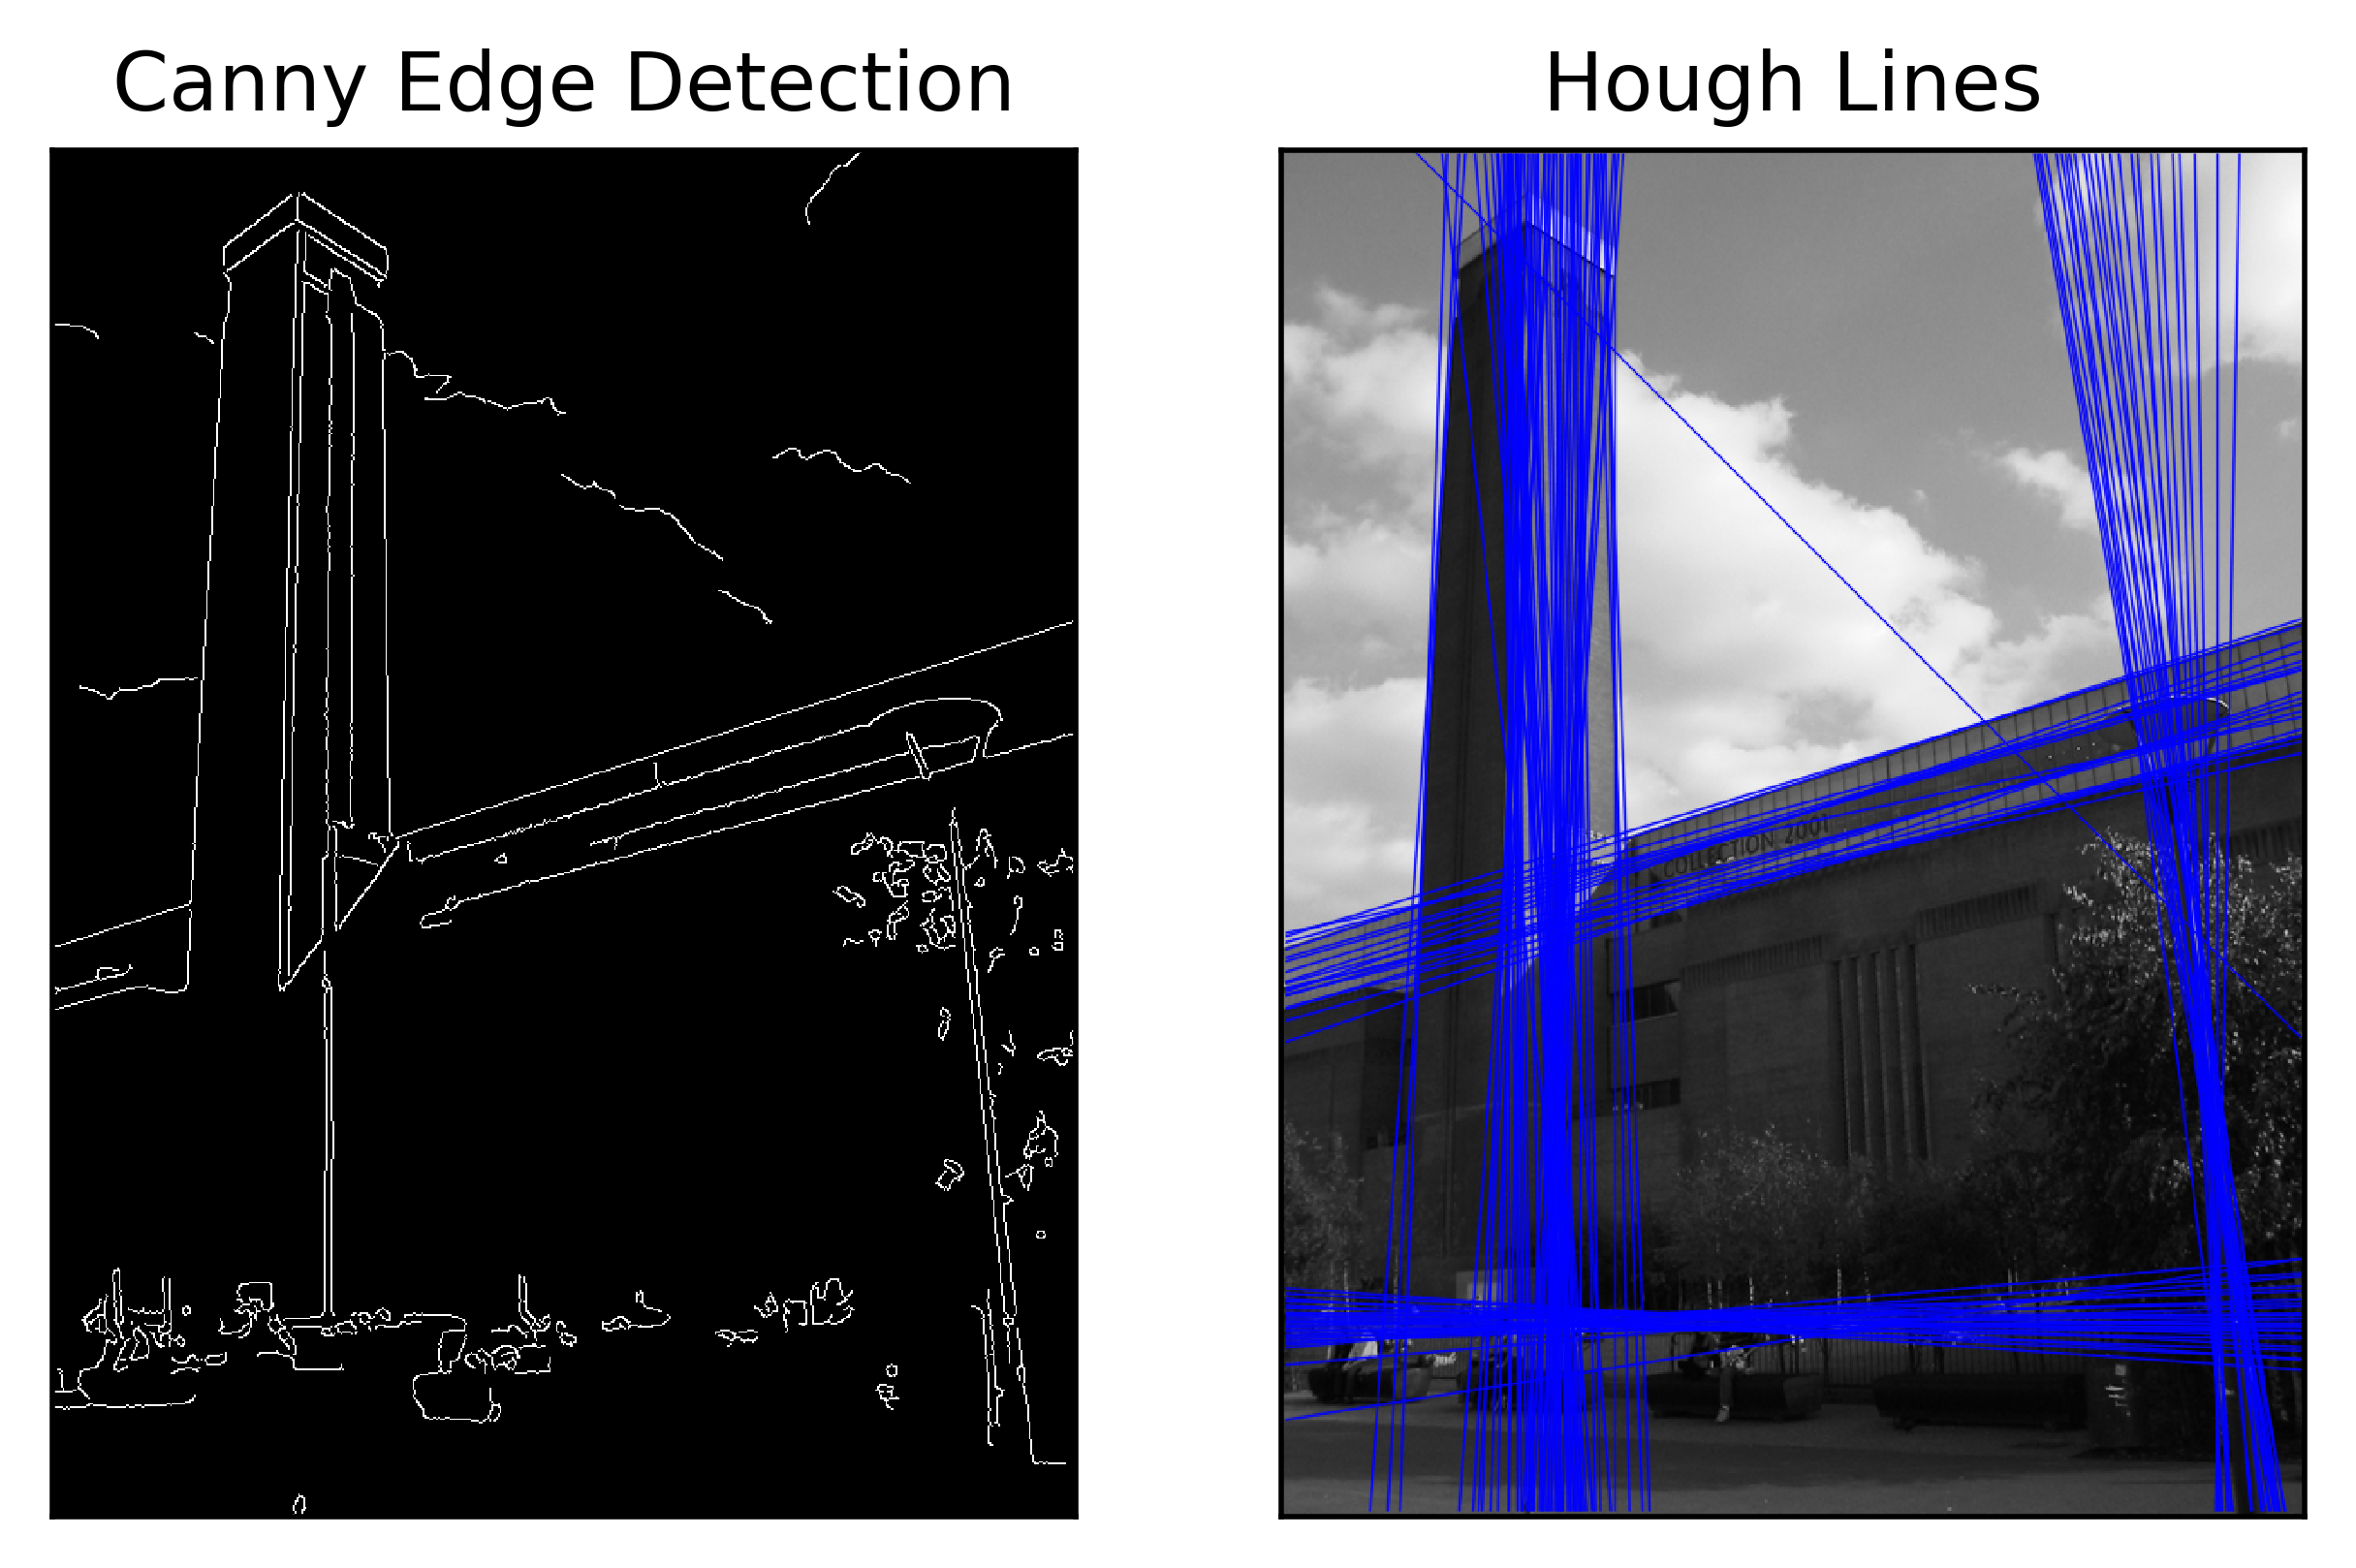

In [9]:
numLines = 0
# Draw the lines
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(img_hough, pt1, pt2, (0,0,255), 1, cv2.LINE_AA)
        numLines += 1

# plot
print("INFO: found " + str(numLines) + " line(s)")
plt.subplot(1, 2, 1)
plt.imshow(canny05, cmap = 'gray')
plt.title('Canny Edge Detection'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(img_hough)
plt.title('Hough Lines'), plt.xticks([]), plt.yticks([])

plt.show()